# MOA Evaluation using enrichment analysis

- Adopted here: https://www.nature.com/articles/s41467-019-10154-8
- Explained here: https://yulab-smu.github.io/clusterProfiler-book/chapter2.html

### Procedure:
1. Compute similarity / correlation / affinity matrix
1. Define MOA matching criteria based on metadata
  - https://github.com/carpenterlab/2018_rohban_natcomm/blob/master/code/moa_evaluations.R#L67
  - https://github.com/carpenterlab/2018_rohban_natcomm/blob/master/code/evaluate.R#L190
1. Find the threshold of top connections (percentile)
1. Run enrichment analysis (one-sided version of Fisher's exact test)
  - https://github.com/carpenterlab/2018_rohban_natcomm/blob/master/code/moa_evaluations.R#L97
  - https://github.com/carpenterlab/2018_rohban_natcomm/blob/master/code/evaluate.R#L205

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import pickle
import sys

sys.path.append("../profiling/")

import metrics
import quality
import profiling

# Load correlation matrix

In [2]:
CORR_MATRIX = "data/correlation_matrix.csv"
#CORR_MATRIX = "data/cr_median_clean.csv"
OUT_RESUTS = "data/EfficientNet_results.pkl"

In [3]:
# df = pd.read_csv("data/cr_median.csv")
# clean = df[df["Unnamed: 0"].isin(df.groupby(["Var1","Var2","value"])["Unnamed: 0"].max().reset_index()["Unnamed: 0"])]
# clean.to_csv("data/cr_median_clean.csv", index=False)

In [4]:
X, Y = profiling.load_correlation_matrix(CORR_MATRIX)

In [5]:
# Z = Y.groupby(["Var1"]).max().reset_index()
# Z[["Var1", "Metadata_moa.x", "Metadata_Plate_Map_Name.x"]].to_csv("data/CDRP_MOA_MATCHES.csv")

# MOA matching

In [6]:
Y.groupby("Metadata_moa.x")["Var1"].count()

Metadata_moa.x
1,3-beta-glucan synthase inhibitor                1
11-beta hydroxysteroid dehydrogenase inhibitor    3
11-beta-HSD1 inhibitor                            1
3-ketoacyl CoA thiolase inhibitor                 1
5 alpha reductase inhibitor                       2
                                                 ..
vitamin B                                         1
vitamin B2                                        1
vitamin D receptor agonist                        2
vitamin K antagonist                              1
voltage-independent calcium influx blocker        1
Name: Var1, Length: 676, dtype: int64

In [7]:
moa_matches = []
for k,r in Y.iterrows():
    moas = r["Metadata_moa.x"].split("|")
    candidates = []
    for m in moas:
        candidates.append(Y["Metadata_moa.x"].str.find(m) != -1)
    matches = candidates[0]
    for c in candidates:
        matches = matches | c
    moa_matches.append(matches)

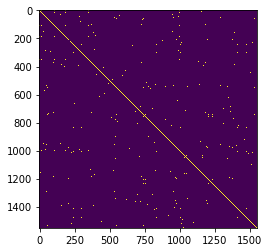

In [8]:
moa_matches = np.asarray(moa_matches)
plt.imshow(moa_matches)

# Enrichment analysis

In [9]:
results = []
Z = np.asarray(X[Y.Var1])
ut_idx = np.triu_indices(moa_matches.shape[1], k=1)

for p in np.arange(98, 99.7, 0.2):
    r = quality.enrichment_analysis_matrix(Z[ut_idx], moa_matches[ut_idx], p)
    results.append(r)

R = pd.DataFrame(data=results)

98.0 0.24328077016327013
[[    644   23397]
 [   6761 1171223]] 1202025
98.2 0.25198510587901013
[[    612   21025]
 [   6793 1173595]] 1202025
98.4 0.26194609444635714
[[    574   18659]
 [   6831 1175961]] 1202025
98.60000000000001 0.27377351172333886
[[    532   16297]
 [   6873 1178323]] 1202025
98.80000000000001 0.2885245447438344
[[    495   13930]
 [   6910 1180690]] 1202025
99.00000000000001 0.30779027035068185
[[    435   11586]
 [   6970 1183034]] 1202025
99.20000000000002 0.33207252555778
[[    368    9249]
 [   7037 1185371]] 1202025
99.40000000000002 0.3671064427838065
[[    301    6912]
 [   7104 1187708]] 1202025
99.60000000000002 0.42293571017326015
[[    236    4573]
 [   7169 1190047]] 1202025


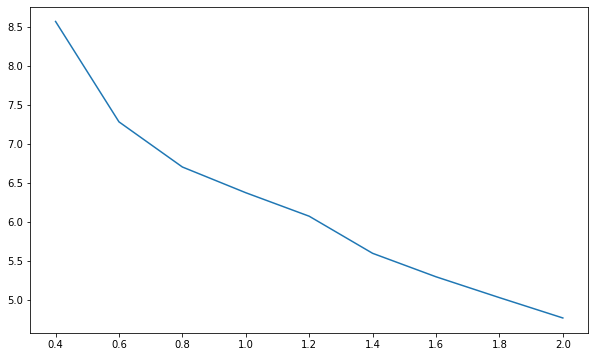

In [10]:
plt.figure(figsize=(10,6))
plt.plot(100-R["percentile"], R["ods_ratio"])

# Average precision analysis

In [11]:
def average_precision(corr_matrix, moa_matches, rank_pos=None):
    results = []
    for i in range(corr_matrix.shape[0]):
        rank = np.argsort(-corr_matrix[i,:])
        ap = metrics.average_precision(moa_matches[i, rank[1:rank_pos]])
        results.append(ap)
    return results

In [12]:
positions = [x for x in range(5,55,5)]
CRM = np.asarray(X[Y.Var1])
map_at = [np.mean( average_precision(CRM, moa_matches, pos) ) for pos in positions]

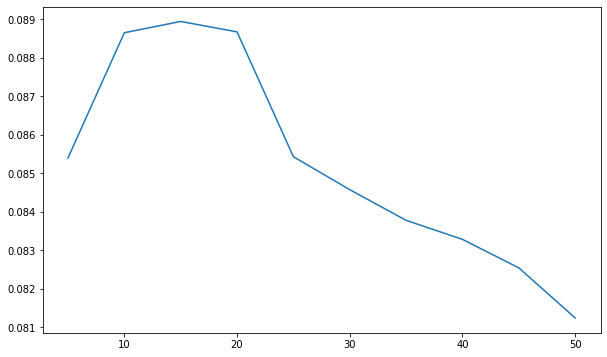

In [13]:
plt.figure(figsize=(10,6))
plt.plot(positions, map_at)

In [14]:
np.mean( average_precision(CRM, moa_matches) )

0.03975858963487495

# Recall analysis

In [15]:
def recall_at(corr_matrix, moa_matches, rank_pos=None):
    results = []
    for i in range(corr_matrix.shape[0]):
        rank = np.argsort(-corr_matrix[i,:])
        rc = np.sum(moa_matches[i, rank[1:rank_pos]]) / np.sum(moa_matches[i,:])
        results.append(rc)
    return results

In [16]:
recall = [np.mean( recall_at(CRM, moa_matches, pos) ) for pos in positions]

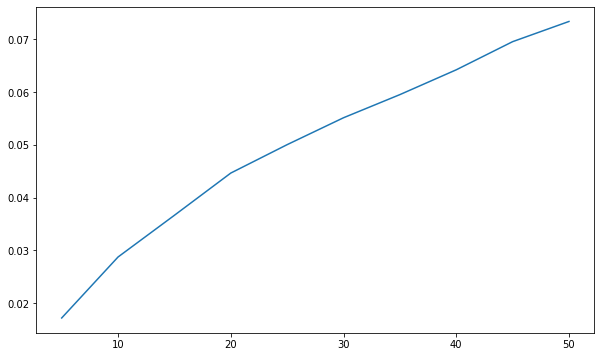

In [17]:
plt.figure(figsize=(10,6))
plt.plot(positions, recall)

In [18]:
np.mean( recall_at(CRM, moa_matches, 50) )

0.07339344407186515

# Save results

In [19]:
results = {
    "enrichment": R,
    "ranking": positions,
    "avg_precision": map_at,
    "recall": recall
}

with open(OUT_RESUTS, "bw") as out:
    pickle.dump(results, out)